# Credit Card Fraud Detection

**Overview**: Credit card fraud leads to financial losses for banks and trust issues for customers whose accounts are compromised. Fraudsters exploit weaknesses in transaction systems, making unauthorized purchases that can go undetected, resulting in chargebacks and reimbursement costs for banks. For customers, fraud causes account freezes, disrupted transactions, and stress from resolving disputes. This model aims to proactively detect fraudulent transactions, minimizing financial risks for banks and reducing customer inconvenience. By accurately identifying fraud, the model helps maintain customer trust while balancing caution to avoid false alarms that could affect legitimate transactions. 

**Explanation of Methods**: This logistic regression model addresses credit card fraud detection by classifying transactions as fraudulent or legitimate. Given the imbalance between rare fraud cases and frequent legitimate transactions, the model uses balanced class weights to improve fraud detection accuracy. The goal is to maximize recall to catch as many fraudulent transactions as possible while minimizing false positives to reduce inconvenience for legitimate users. Performance is evaluated using metrics like precision, recall, and ROC-AUC, achieving high fraud detection rates with some trade-offs in precision. The model aims to enhance proactive fraud prevention in financial institutions.in the Data

<b>Importing packages, importing data, and basic data cleaning</b>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

In [2]:
# Data Loading and Cleaning
data = pd.read_csv('data/CreditCardData.csv')
data['Amount'] = data['Amount'].replace('[£$,]', '', regex=True).astype(float)

# Handling Missing Values
data_cleaned = data.dropna(subset=['Amount', 'Merchant Group', 'Shipping Address', 'Gender'])

In [ ]:
# Exploratory Data Analysis (EDA)

<b>1. Fraud Distribution</b>
<b>Visualization Summary:</b>

<li>The bar chart displays the distribution of fraudulent (1) versus legitimate (0) transactions in the dataset.</li>
<li>There is a significant imbalance, with legitimate transactions vastly outnumbering fraudulent ones.</li>

<br>
<b>Data Insights:</b>

<li>Despite their rarity, fraudulent transactions have disproportionate financial and reputational impact.</li>
<li>Therefore, the model should focus on optimizing for recall (to catch as many fraudulent transactions as possible) while managing precision (to minimize false positives).</li>

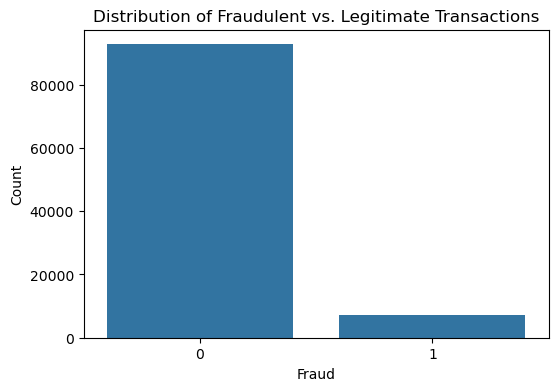

In [3]:
# Fraud distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Fraud', data=data_cleaned)
plt.title('Distribution of Fraudulent vs. Legitimate Transactions')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.show()

<b>2. Transaction Amounts by Fraud Status</b>
<b>Visualization Summary:</b>

<li>This boxplot compares the distribution of transaction amounts between fraudulent (1) and legitimate (0) transactions.</li>
<li>The y-axis is limited to $500 to provide a clearer view of the data, filtering out extreme outliers.</li>

<br>
<b>Data Insights:</b>

<li>The median transaction amount for fraudulent transactions is lower compared to legitimate ones.</li>
<li>This suggests that fraudsters might perform small-value transactions to avoid triggering detection systems.</li>
<li>There are noticeable outliers among fraudulent transactions, indicating that while most fraudulent activities involve small amounts, some can involve high-value transactions.</li>
<li>The presence of high-value legitimate transactions could complicate fraud detection if the model over-relies on transaction amounts.</li>

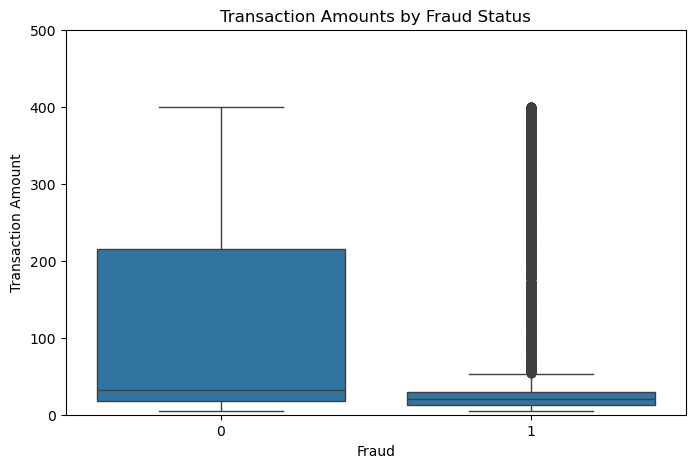

In [4]:
# Transaction Amounts by Fraud Status
plt.figure(figsize=(8, 5))
sns.boxplot(x='Fraud', y='Amount', data=data_cleaned)
plt.title('Transaction Amounts by Fraud Status')
plt.xlabel('Fraud')
plt.ylabel('Transaction Amount')
plt.ylim(0, 500)
plt.show()

<b>3. Transaction Frequency by Hour and Fraud Status</b>
<b>Visualization Summary:</b>

<li>The histogram illustrates transaction counts across different hours of the day, with a breakdown of fraudulent (1) and legitimate (0) transactions.</li>
<li>The x-axis represents the hour of the day (0-24), and the y-axis shows the number of transactions.</li>
<li>The bars are stacked to show how much of the total transaction volume at each hour is fraudulent versus legitimate.</li>

<br>
<b>Data Insights:</b>

<li>Fraudulent transactions appear to occur more frequently during the late-night and early morning hours (midnight to 6 AM).</li>
<li>This pattern could be due to fraudsters attempting to exploit systems when monitoring activity is lower or users are less likely to notice unauthorized activity immediately.</li>
<li>Legitimate transactions are more evenly distributed throughout the day, with a noticeable peak during business hours (8 AM to 6 PM).</li>
<li>The contrast between fraudulent and legitimate transaction patterns suggests that time of day could be a strong predictor of fraud.</li>
<li>Transactions occurring during off-peak hours (midnight to early morning) could be flagged for additional scrutiny.</li>

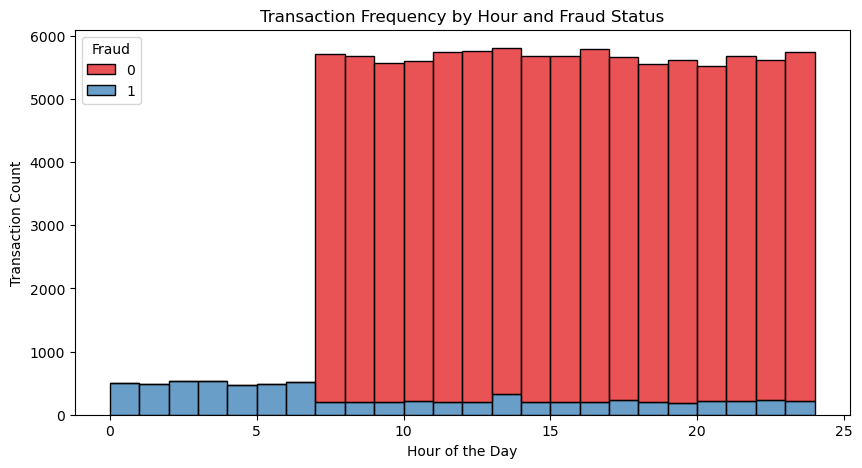

In [5]:
# Transaction Frequency by Time of Day
plt.figure(figsize=(10, 5))
sns.histplot(data=data_cleaned, x='Time', bins=24, hue='Fraud', multiple='stack', palette='Set1')
plt.title('Transaction Frequency by Hour and Fraud Status')
plt.xlabel('Hour of the Day')
plt.ylabel('Transaction Count')
plt.show()

<b>4. Type of Card Usage by Fraud Status</b>
<b>Visualization Summary:</b>

<li>This bar chart compares the frequency of Visa and MasterCard transactions, segmented by fraudulent (1) and legitimate (0) transactions.</li>
<li>The x-axis represents the type of card, while the y-axis shows the transaction count.</li>
<li>The bars are color-coded to distinguish between legitimate (red) and fraudulent (blue) transactions.</li>

<br>
<b>Data Insights:</b>

<li>Visa cards have a slightly higher number of fraudulent transactions compared to MasterCard, likely due to Visa's larger market share</li>
<li>While Visa has more fraud cases in total, the proportional fraud rate between Visa and MasterCard appears to be relatively similar.</li>
<li>This suggests that card type alone might not be a strong differentiator for fraud detection but could still contribute when combined with other features.</li>
<li>The number of legitimate transactions is significantly higher for both Visa and MasterCard, reaffirming the class imbalance observed in the dataset.</li>
l scrutiny.

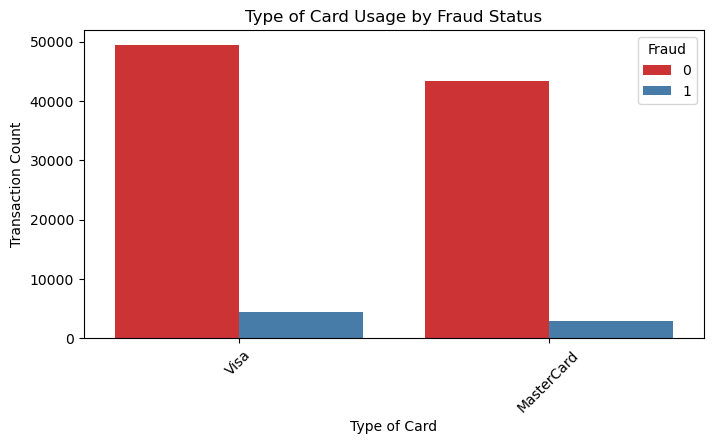

In [6]:
# Type of Card Usage by Fraud Status
plt.figure(figsize=(8, 4))
sns.countplot(data=data_cleaned, x="Type of Card", hue="Fraud", palette="Set1")
plt.title("Type of Card Usage by Fraud Status")
plt.xlabel("Type of Card")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.show()

<b>5. Entry Mode by Fraud Status</b>
<b>Visualization Summary:</b>

<li>This bar chart displays the distribution of transactions based on entry mode (Tap, PIN, CVC), segmented by fraudulent (1) and legitimate (0) transactions.</li>
<li>The x-axis represents the entry mode, while the y-axis shows the transaction count.</li>
<li>Fraudulent transactions are shown in orange, and legitimate transactions are in green.</li>

<br>
<b>Data Insights:</b>

<li>The CVC (Card Verification Code) entry mode shows a higher proportion of fraudulent transactions compared to Tap and PIN.</li>
<li>This suggests that online or card-not-present transactions, where CVC is commonly used, are more susceptible to fraud due to less stringent verification.</li>
<li>Transactions using PIN entry have the lowest proportion of fraud.</li>
<li>This is expected because PIN-based transactions require two-factor authentication, making it harder for fraudsters to execute unauthorized transactions.</li>
<li>The Tap entry mode shows moderate fraud levels, likely due to the ease of performing contactless transactions, especially for small amounts that don't require additional authentication.</li>

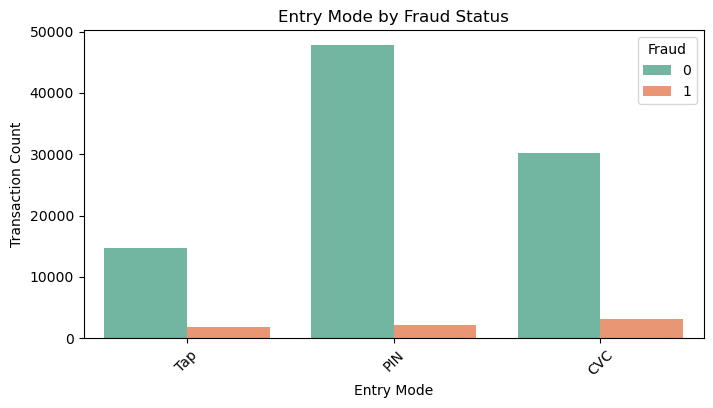

In [7]:
# Entry Mode by Fraud Status
plt.figure(figsize=(8, 4))
sns.countplot(data=data_cleaned, x="Entry Mode", hue="Fraud", palette="Set2")
plt.title("Entry Mode by Fraud Status")
plt.xlabel("Entry Mode")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.show()

<b>6. Merchant Group by Fraud Status</b>
<b>Visualization Summary:</b>

<li>This horizontal bar chart visualizes transaction counts across different merchant groups, segmented by fraudulent (1) and legitimate (0) transactions.</li>
<li>The y-axis represents merchant categories (e.g., Electronics, Fashion, Gaming), while the x-axis shows the transaction count.</li>
<li>Fraudulent transactions are shown in yellow, and legitimate transactions in light green.</li>

<br>
<b>Data Insights:</b>

<li>Electronics and Fashion categories show noticeably higher fraud counts compared to other merchant groups.</li>
<li>Fraudsters often target high-value, easily resellable goods, which explains the increased fraud in these sectors.</li>
<li>Gaming and Subscription services display moderate fraud rates, potentially due to the popularity of digital goods and recurring billing models that can be exploited.</li>
<li>Categories like Food and Children's Products have relatively lower fraud rates, possibly because these transactions are more typical of legitimate day-to-day purchases and hold less resale value.</li>


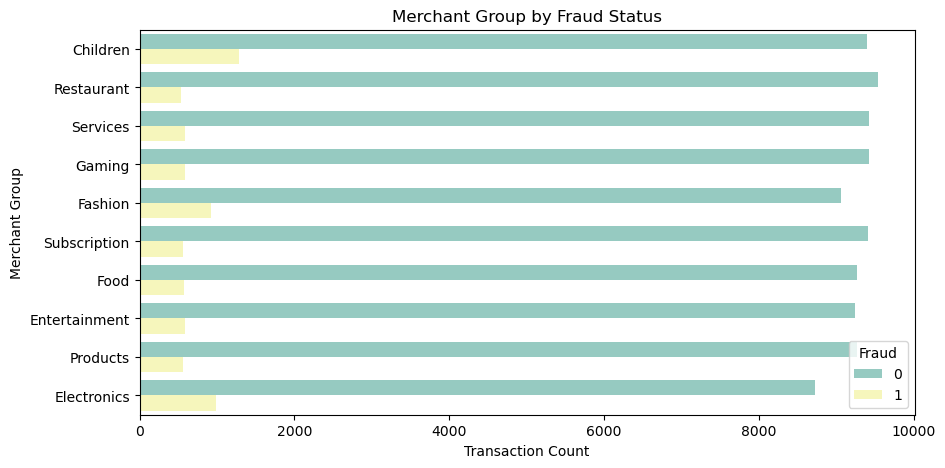

In [8]:
# Merchant Group by Fraud Status
plt.figure(figsize=(10, 5))
sns.countplot(data=data_cleaned, y="Merchant Group", hue="Fraud", palette="Set3",
              order=data_cleaned["Merchant Group"].value_counts().index)
plt.title("Merchant Group by Fraud Status")
plt.xlabel("Transaction Count")
plt.ylabel("Merchant Group")
plt.show()

<b>7. Country Mismatch and Fraud Relationship</b>
<b>Visualization Summary:</b>

<li>This bar chart illustrates the relationship between country mismatches (where the transaction country differs from the cardholder's country of residence) and the occurrence of fraud.</li>
<li>The x-axis shows whether there was a country mismatch (1 = Yes, 0 = No), while the y-axis represents the transaction count.</li>
<li>Transactions are color-coded to differentiate between legitimate (0) in red and fraudulent (1) in blue.</li>

<br>
<b>Data Insights:</b>

<li>Transactions with a country mismatch exhibit a disproportionately higher rate of fraud compared to transactions where the transaction and residence countries match.</li>
<li>This indicates that fraudsters often operate across borders, leveraging the difficulty of verifying international transactions.</li>
<li>The majority of legitimate transactions occur when the transaction and residence countries match, reflecting typical consumer behavior.</li>
<li>While mismatched transactions are more likely to be fraudulent, there are still legitimate international transactions (e.g., travel-related purchases, online global retailers).</li>
<li>This underscores the need to combine country mismatch with other features like transaction amount, time, and merchant category for accurate fraud detectio</li>

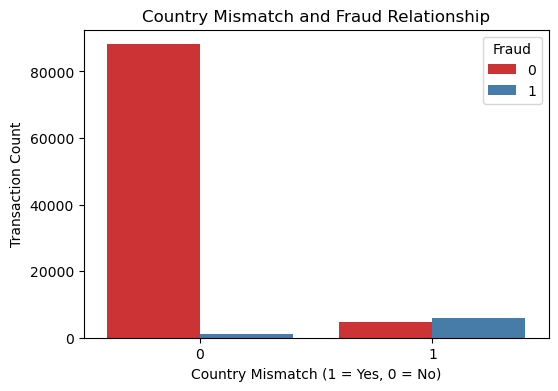

In [49]:
# Country Mismatch Feature
mismatch = data_cleaned["Country of Transaction"] != data_cleaned["Country of Residence"]
data_cleaned.loc[:, "Country Mismatch"] = mismatch.astype(int)

plt.figure(figsize=(6, 4))
sns.countplot(x="Country Mismatch", hue="Fraud", data=data_cleaned, palette="Set1")
plt.title("Country Mismatch and Fraud Relationship")
plt.xlabel("Country Mismatch (1 = Yes, 0 = No)")
plt.ylabel("Transaction Count")
plt.show()

<b>8. Gender Distribution by Fraud Status</b>
<b>Visualization Summary:</b>

<li>This bar chart compares the distribution of transactions between males (M) and females (F), segmented by fraudulent (1) and legitimate (0) transactions.</li>
<li>The x-axis represents gender, while the y-axis shows the transaction count.</li>
<li>Legitimate transactions are shown in green, while fraudulent transactions are displayed in orange.</li>

<br>
<b>Data Insights:</b>

<li>Both males and females exhibit similar proportions of fraudulent transactions relative to legitimate transactions.</li>
<li>There is a slightly higher count of fraudulent transactions among males compared to females.</li>
<li>The number of legitimate transactions is almost identical for both genders, suggesting a balanced dataset in terms of gender representation for normal transactions.</li>
<li>This indicates that gender is not a strong distinguishing factor in predicting fraud in this dataset.</li>

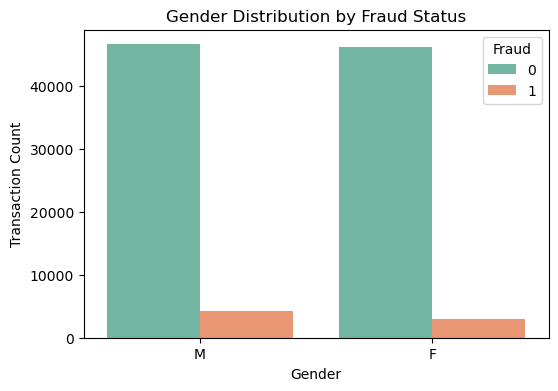

In [10]:
# Gender Distribution by Fraud Status
plt.figure(figsize=(6, 4))
sns.countplot(data=data_cleaned, x="Gender", hue="Fraud", palette="Set2")
plt.title("Gender Distribution by Fraud Status")
plt.xlabel("Gender")
plt.ylabel("Transaction Count")
plt.show()

<b>9. Age Distribution by Fraud Status</b>
<b>Visualization Summary:</b>

<li>This histogram displays the distribution of transaction counts across different age groups, segmented by fraudulent (1) and legitimate (0) transactions.</li>
<li>The x-axis represents age, while the y-axis shows the number of transactions.</li>
<li>A Kernel Density Estimation (KDE) curve is overlaid to highlight the distribution trends for both fraudulent (blue) and legitimate (red) transactions.</li>

<br>
<b>Data Insights:</b>

<li>Fraudulent transactions are most common among individuals aged 35 to 50.</li>
<li>This could reflect the fact that people in this age range are often more financially active and thus more targeted by fraudsters.</li>
<li>The distribution of legitimate transactions forms a bell-shaped curve, peaking around ages 40 to 50.</li>
<li>This suggests that middle-aged individuals are the most active in terms of transaction volume, aligning with typical spending behavior.</li>
<li>Both younger (under 30) and older (over 60) age groups exhibit fewer fraudulent transactions.</li>

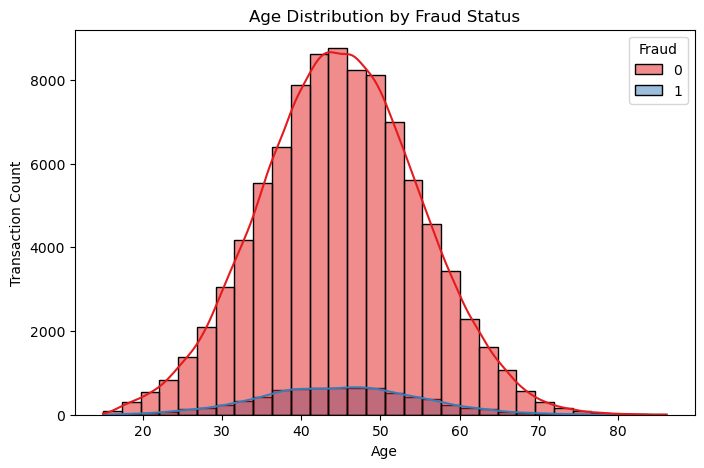

In [11]:
# Age Distribution by Fraud Status
plt.figure(figsize=(8, 5))
sns.histplot(data=data_cleaned, x="Age", hue="Fraud", bins=30, kde=True, palette="Set1")
plt.title("Age Distribution by Fraud Status")
plt.xlabel("Age")
plt.ylabel("Transaction Count")
plt.show()

<b>Feature Engineering</b>

<li>LabelEncoder is being used to convert categorical features into numerical values.</li>
<li>A new feature called 'Time of Day' is being created based on the transaction time, categorizing transactions into Morning, Afternoon, Evening, or Night.  This categorization is then used to encode to numerical values.</li>
<li>A feature called 'Country Mismatch' is created to flag transactions where the 'Country of Transaction' differs from the 'Country of Residence'.</li>


In [56]:
# Feature Engineering: Encoding Categorical Variables Safely with Explicit Casting
le = LabelEncoder()
categorical_features = ['Type of Card', 'Entry Mode', 'Type of Transaction',
                        'Merchant Group', 'Country of Transaction', 'Shipping Address',
                        'Country of Residence', 'Gender', 'Bank']

for feature in categorical_features:
    data_cleaned.loc[:, feature] = le.fit_transform(data_cleaned[feature]).astype('int32')


# Creating Time of Day Feature safely with Explicit Casting
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data_cleaned.loc[:, 'Time of Day'] = data_cleaned['Time'].apply(time_of_day)
data_cleaned.loc[:, 'Time of Day'] = le.fit_transform(data_cleaned['Time of Day']).astype('int32')

# Ensuring country mismatch feature is updated safely with explicit casting
mismatch = data_cleaned["Country of Transaction"] != data_cleaned["Country of Residence"]
data_cleaned.loc[:, "Country Mismatch"] = mismatch.astype('int32')

<b>Logistic Regression Model</b>
<li>Features: These are all the variables that the model will use to predict fraud (e.g., transaction amount, time of day, merchant group).</li>
<li>Target: This is the variable we're trying to predict. In this case, 'Fraud' is a binary variable, with 0 being a legitimate transaction, and 1 being a fraudulent transaction.</li>
<li>Training & Testing: The dataset is split into training data (to teach the model) and testing data (to evaluate how well the model performs). 70% of data is used for training, with the remaining 30% used for testing.  "stratify=target" is in place to ensure that the ratio between fraudulent and legitimate transactions are kept between the two data sets.</li>
<li>Training the model: Using Logistic Regression with 1000 iterations and a class weight of "balanced", which instructs the model to pay more attention to fraudulent transactions, which are rarer.</li>
<li>Making Preductions: The model is used to predict fraud on the test dataset</li>
<li>Performance Evaluation: Using Confusion Matrix, Classification Report, ROC-AUC Score, and ROC Curve are used to interpret performance</li>


In [13]:
# Baseline Model: Logistic Regression
features = data_cleaned.drop(columns=['Transaction ID', 'Date', 'Day of Week', 'Fraud'])
target = data_cleaned['Fraud']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# Classification Metrics
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)


<b>Model Performance/Eval</b>
<li>Classification Report: A precision of 0.53 means that only 53% of transactions flagged as fraud were actually fraud.  This is low, and indicative of a need to rely heavily on Recall.  The Recall of 0.93 means that the model caught 93% of all actual fraud cases. This is critical in fraud detection, where missing fraud is costly.  This is a good result.  The F1-score of 0.67 indicates a good balance but suggests room for improvement, especially in precision.</li>
<li>ROC Curve:  With a displayed result of 0.9745, this is an excellent result and indicates that the model would catch most fraud transactions</li>
<li>Confusion Matrix: The model correctly identified 26,032 legitimate transactions.  This is a good represenations of non-fraud activity being correctly identified.  The model mistakenly flagged 1,804 legitimate transactions as fraud.  This could lead to customer complaints, but may be better than the alternative.  The model missed 159 fraudulent transactions, predicting them as legitimate.  This number is low, but could cost the bank money.  The model correctly identified 1,999 fraudulent transactions.  These true positives represent an excellent result.</li>


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96     27836
           1       0.53      0.93      0.67      2158

    accuracy                           0.93     29994
   macro avg       0.76      0.93      0.82     29994
weighted avg       0.96      0.93      0.94     29994

Confusion Matrix:
 [[26032  1804]
 [  159  1999]]
ROC-AUC Score: 0.9745


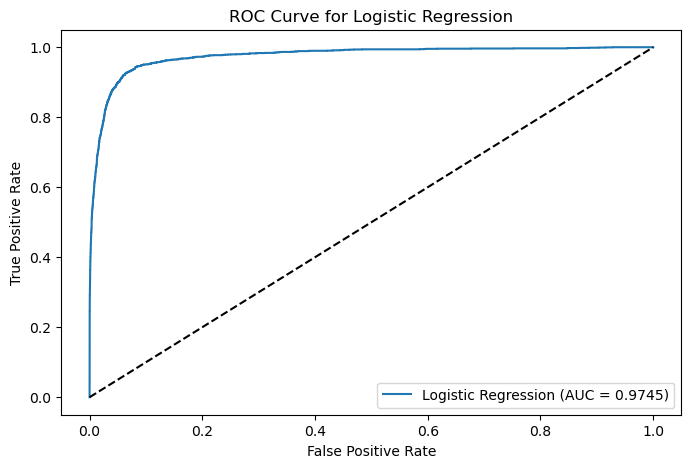

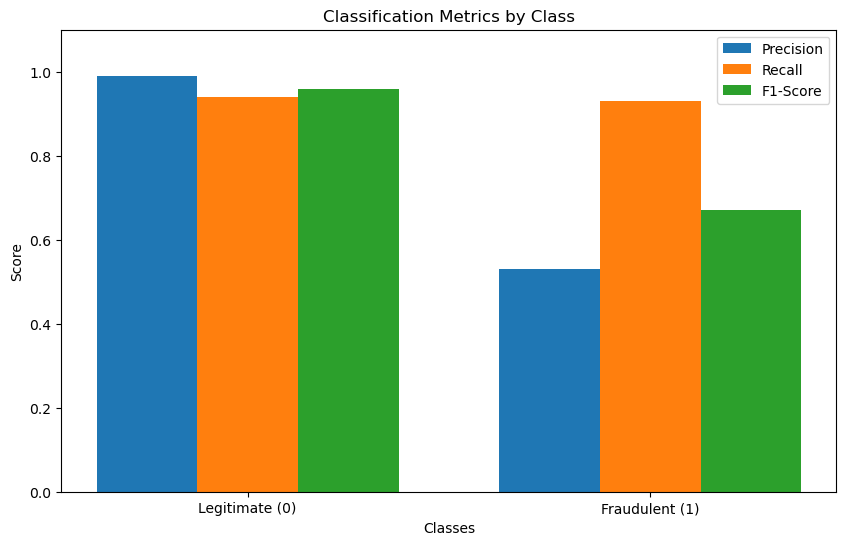

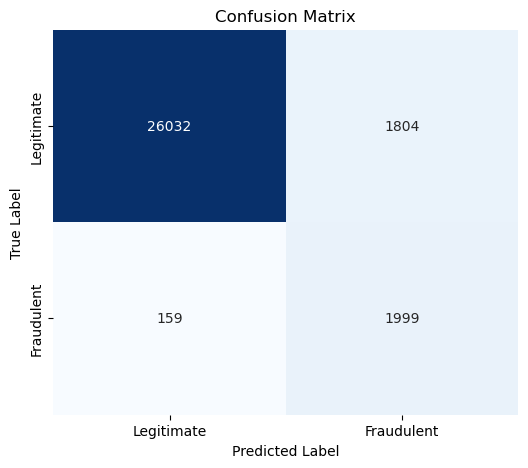

In [14]:
# Displaying Basic Results
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# ROC Curve Visualization
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Additional Visualizations for Classification Metrics

# 1. Bar Chart for Precision, Recall, and F1-Score
labels = ['Legitimate (0)', 'Fraudulent (1)']
precision_vals = [0.99, 0.53]
recall_vals = [0.94, 0.93]
f1_scores_vals = [0.96, 0.67]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision_vals, width, label='Precision')
plt.bar(x, recall_vals, width, label='Recall')
plt.bar(x + width, f1_scores_vals, width, label='F1-Score')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Classification Metrics by Class')
plt.xticks(x, labels)
plt.ylim(0, 1.1)
plt.legend()
plt.show()

# 2. Confusion Matrix Heatmap
conf_matrix_values = np.array([[26032, 1804],
                               [159, 1999]])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_values, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()